# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Шаги для выполнения:
- Загрузим данные
- Подготовим данные
- Обучим модели
- Проанализируем модели
- Сделаем общий вывод

Описание данных:
* Признаки
    * DateCrawled — дата скачивания анкеты из базы
    * VehicleType — тип автомобильного кузова
    * RegistrationYear — год регистрации автомобиля
    * Gearbox — тип коробки передач
    * Power — мощность (л. с.)
    * Model — модель автомобиля
    * Kilometer — пробег (км)
    * RegistrationMonth — месяц регистрации автомобиля
    * FuelType — тип топлива
    * Brand — марка автомобиля
    * Repaired — была машина в ремонте или нет
    * DateCreated — дата создания анкеты
    * NumberOfPictures — количество фотографий автомобиля
    * PostalCode — почтовый индекс владельца анкеты (пользователя)
    * LastSeen — дата последней активности пользователя
* Целевой признак
    * Price — цена (евро)

**Импортируем необходимые библиотеки**

In [55]:
!pip install lightgbm
!pip install catboost
import phik
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
RANDOM_STATE = 42
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import time

**Загрузим и просмотрим данные:**

In [56]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

Просмотрим данные

In [57]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Подготовка данных

Просмотрим общую информацию о данных:

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Теперь выведем колличество явных дубликатов и пропусков

In [60]:
display((df.isna().mean() * 100).sort_values(ascending=False))
display((df.isna()).sum().sort_values(ascending=False))
display('Количество явных дубликатов:',df.duplicated().sum())
display(df.shape)

Repaired             20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

'Количество явных дубликатов:'

4

(354369, 16)

Вывод по загрузке данных:
* Датафрейм состоит из 354369 строк и 16 столбцов
* Пропуски присутствуют в столбцах: Repaired,VenicleType,FuelType,GearBox,Model
* Присутствуют явные дубликаты: 4
* Типы данных соответствуют

Стоит добавить, что пропуски в столбце Repaired, скорее всего связано с тем, что продавец не указал была ли в ремонте машина. Пропуски в столбце VenichleType - вероятнее всего человек либо забыл указать, либо авто не подходило ни к одной из категорий. FuelType,Gearbox,Model - по тем же причинам.

###  Предобработка данных

**Обработка пропусков**

Учитывая,что доли пропущенных значений довольно велики, стоит сразу отсеять вариант удаления всех строк с пропущенными значениями, наши данные сильно пострадают при таком действии. Так как признаки в которых есть пропуски, являются категорийными, лучшим вариантов разобраться с пропусками считаю - заполнить пропущенные значения, значениями наиболее часто встречающимися(то есть модой). Так мы сможем сохранить данные, хоть и качество этих данных может немного пострадать.

In [61]:
df['Repaired'] = df['Repaired'].fillna(df['Repaired'].mode().values[0])
df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType'].mode().values[0])
df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode().values[0])
df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode().values[0])
df['Model'] = df['Model'].fillna(df['Model'].mode().values[0])
# Проверим
display(df['Repaired'].unique())
display(df['VehicleType'].unique())
display(df['FuelType'].unique())
display(df['Gearbox'].unique())
display(df['Model'].unique())


array(['no', 'yes'], dtype=object)

array(['sedan', 'coupe', 'suv', 'small', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

array(['manual', 'auto'], dtype=object)

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

**Обработка дубликатов**

Просмотрим дубликаты

In [62]:
df[df.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
189060,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,gasoline,audi,no,2016-04-04 00:00:00,0,65428,2016-04-05 12:30:14
194008,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,gasoline,audi,no,2016-04-04 00:00:00,0,65428,2016-04-05 12:30:14
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим их

In [63]:
df = df.drop_duplicates()
# Проверим
df.duplicated().sum()

0


<div class="alert alert-block alert-info">
<b>Совет:</b> У fuel_type есть категории, которые означают одно и тоже - их можно объединить, либо подумать может они действительно означают, что-то разное.
</div>

### Исследовательский анализ данных

Просмотрим сначала распределения категориальных признаков. Признак Model рассмотрим отдельно

In [64]:
def plot_features_cat(df):
    # Определяем признаки для визуализации
    features = ['VehicleType','Gearbox','FuelType','Brand','Repaired',]

    # Создаем фигуру и оси для графиков
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = axes.flatten()  # Упрощаем доступ к осям

    # Построение графиков для каждого признака
    for i, feature in enumerate(features):
        sns.countplot(df[feature], ax=axes[i],color='blue')
        axes[i].set_title(f'Распределение {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Частота')

    # Настройка общего оформления графиков
    plt.tight_layout()
    plt.show()

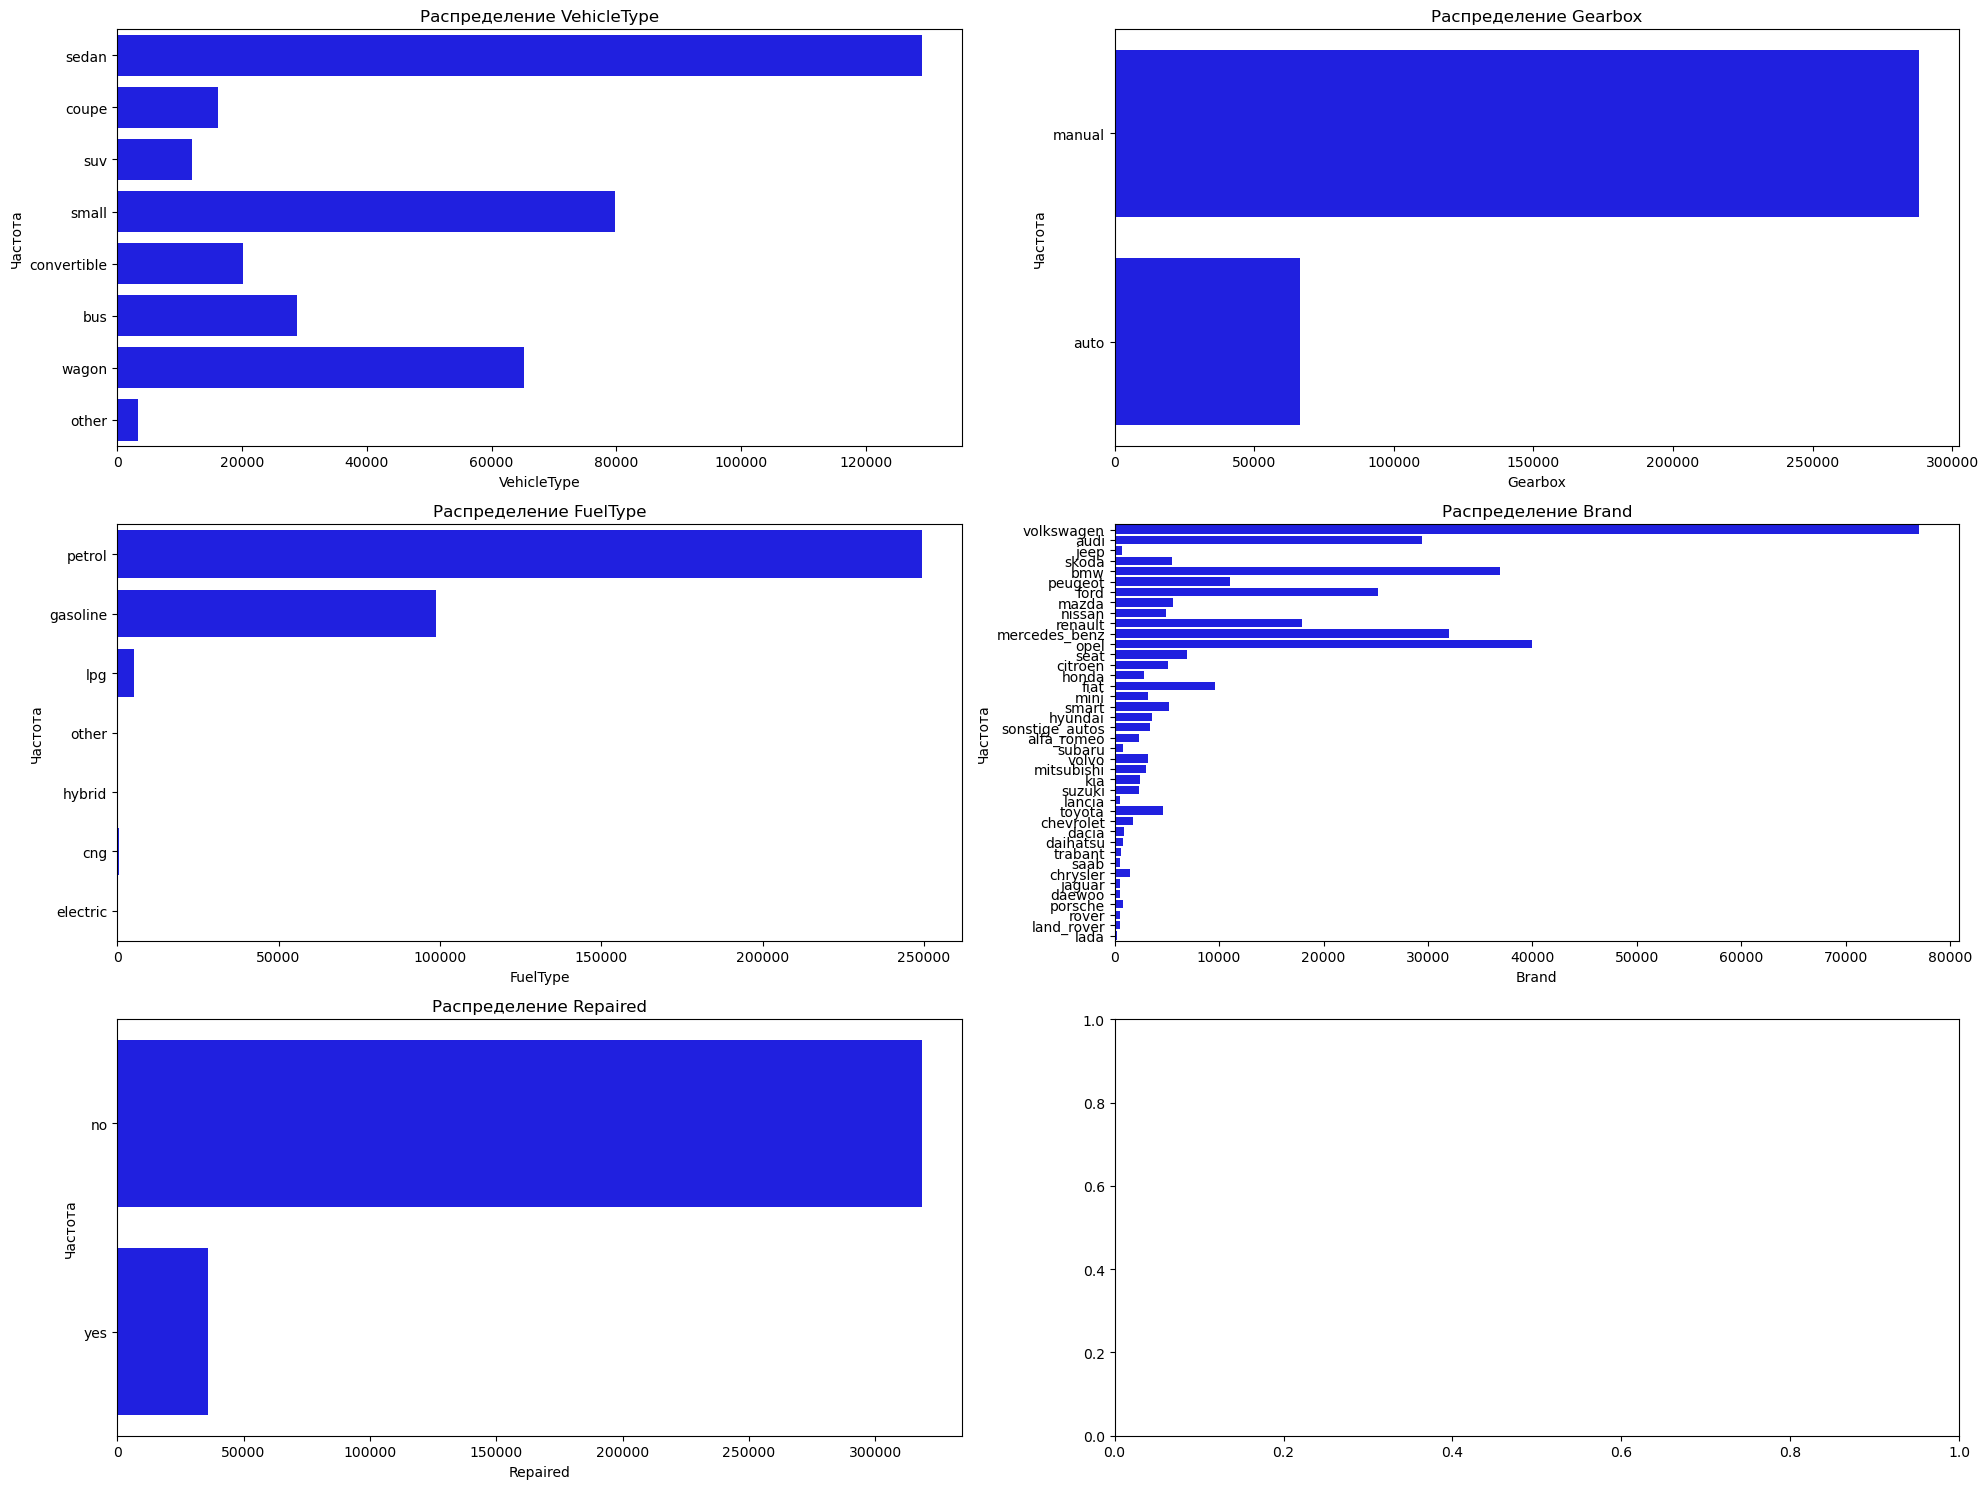

In [65]:
plot_features_cat(df)

Следуя из графиков можем сказать:
- Среди столбца VehicleType лидерами являются седаны, маленькие авто, фургоны, наименьшие значения имеют внедорожники и категория "другие" авто
- Среди столбца Gearbox лидерами являются машины с ручной коробкой переключения передач
- Среди столбца FuelType выделяются автомобили на бензине и газе, электроавтомобили и гибридные составляют наименьшую долю
- Среди столбца Brand, больше всего автомобилей от таких марок как: volkswagen,mercedes_benz,bmw, меньше всего автомобилей lada
- Среди столбца Repaireed, большинство машин не были в ремонте  

Перед просмотром распределений для колличественных признаков, удалим ненужные признаки, которые не связаны с автомибилями:

In [66]:
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis=1)

Рассмотрим колличественные признаки

In [67]:
def plot_feature_kol(df):
    # Определяем признаки для визуализации
    features = ['Price','RegistrationYear','Power','Kilometer','RegistrationMonth']

    # Создаем фигуру и оси для графиков
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    axes = axes.flatten()  # Упрощаем доступ к осям

    # Построение графиков для каждого признака
    for i, feature in enumerate(features):
        sns.histplot(df[feature], ax=axes[i], kde=True, color='blue', bins=7)
        axes[i].set_title(f'Распределение {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Значения')

    # Настройка общего оформления графиков
    plt.tight_layout()
    plt.show()

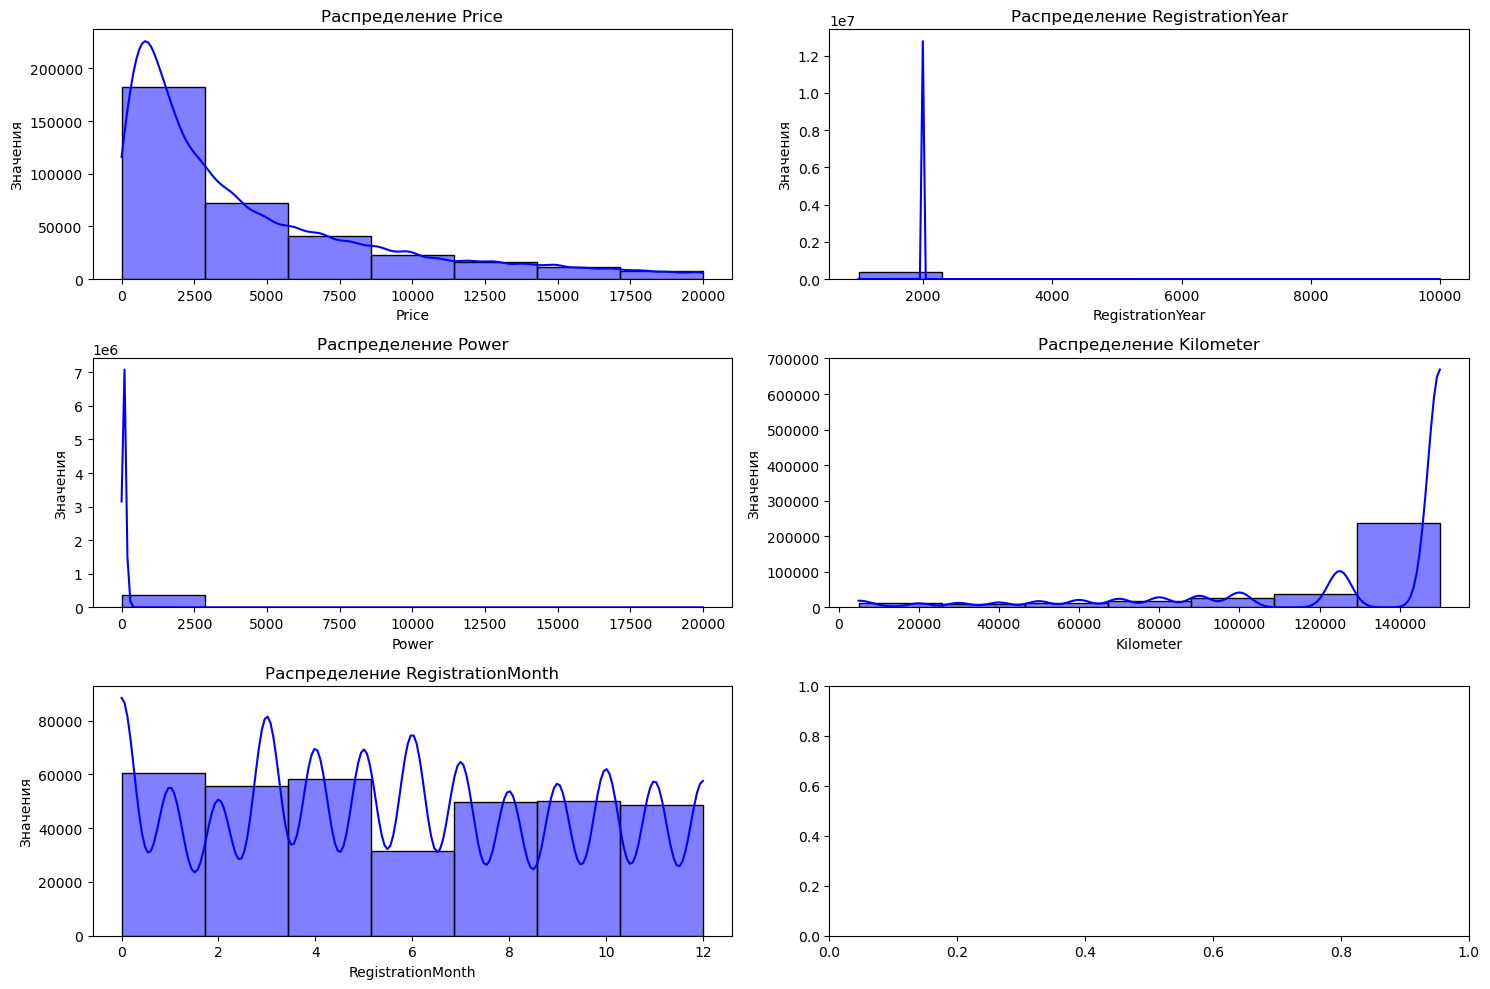

In [68]:
plot_feature_kol(df)

Теперь выведим общую информацию по датафрейму

In [69]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641
std,4514.159690,90.228593,189.851590,37905.136957,3.726433
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


**Вывод по исследовательскому анализу данных:**
- Данные в столбце Price имеют довольно большое стандартное отклонение, максимальное значение - 20000 а минимальное 0, средняя цена 4416, распределение не похоже на нормальное
- Данные в столбце RegistrationYear - минимальное значение 1000, а максимальное 9999, что точно говорит о том что в данных есть аномалии, стоит убрать эти аномалии
- Данные в столбце Power - минимальное значение 0 а максимальное значение 20000, также говорит нам о том что в данных есть аномалии, уберем выбросы
- Данные в столбце Kilometer - минимальное значение 5000, а максимальное 150000, данные выглядят как реальные, выбросов нет.
- Данные в RegistrationMonth - минимальное значение 0, а максимальное 12, значение 0 говорит о нулевом месяце, которого не существует, следует обработать

**Обработка выбросов**

**Примим решения по выбросам:**
- В столбце RegustrationYear следует ограничить данные, которые выходят за пределы, порогом обозначим 1920 год, а пределом 2020 годом
- В столбце RegistrationMonth заменим 0 месяц на 1 месяц
- В столбце Power ограничим значения 3500, так как на данный момент самое большое колличетсво лошадинных сил имеети автомобиль Saleen s7-3000 л.с.
- В столбце Power разберемся с выбросами на основе межквартального размаха

In [70]:
# Балансировка RegistrationYear
df["RegistrationYear"] = np.clip(df["RegistrationYear"], 1920, 2020)

# Замена 0 на 1 в RegistrationMonth
df["RegistrationMonth"] = df["RegistrationMonth"].replace(0, 1)

# Ограничение Power
df["Power"] = np.clip(df["Power"], 1, 3500)

### Корреляционный анализ данных

Целевой признак в нашем исследовании - Price, стоит рассмотреть есть ли зависимости между признаками

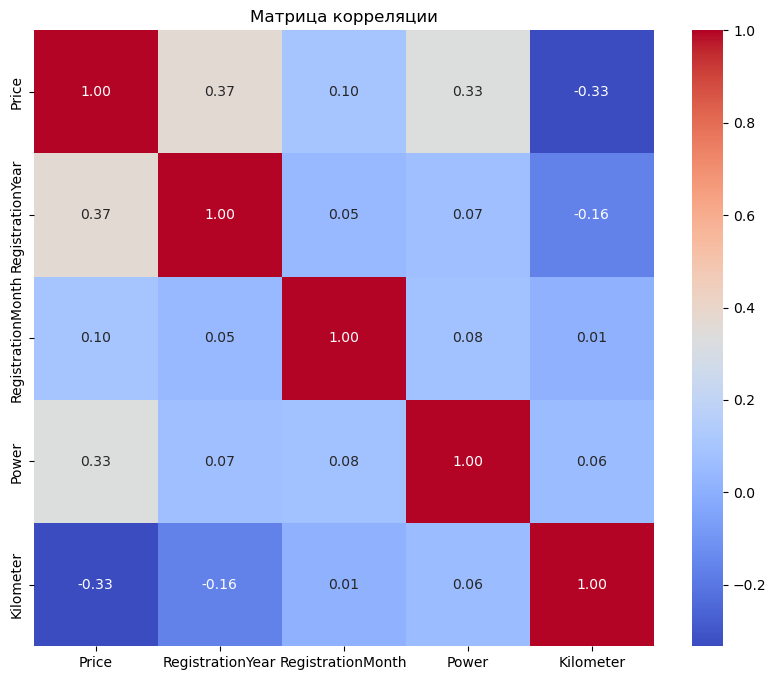

In [71]:
correlation_matrix = df[['Price', 'RegistrationYear', 'RegistrationMonth', 'Power', 'Kilometer']].corr()
# Выводим матрицу корреляции
# Визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

**Вывод по корреляционному анализу данных:**
- Наибольшую корреляцию имеют признаки RegistrationYear и Power, 0.37 и 0.33 соответственно, остальные признаки имеют иное либо отрицательное значение. Коэффиценты в порядке, мультиколлинеарности нет, данные не следует менять.

###  Общий вывод по подготовке данных
* Загрузили данные:
    * Датафрейм состоит из 354369 строк и 16 столбцов
    * Пропуски присутствуют в столбцах: Repaired,VenicleType,FuelType,GearBox,Model
    * Присутствуют явные дубликаты: 4
    * Типы данных соответствуют
* Предобработали данные:
    * Учитывая,что доли пропущенных значений довольно велики, отсеяли вариант удаления всех строк с пропущенными значениями, наши данные сильно пострадают при таком действии. Так как признаки в которых есть пропуски, являются категорийными, лучшим вариантов разобраться с пропусками считаю - заполнить пропущенные значения, значениями наиболее часто встречающимися(то есть модой). Так мы сможем сохранить данные, хоть и качество этих данных может немного пострадать.
    * Обработали дубликаты
* Провели исследовательский анализ данных:
    * Среди столбца VehicleType лидерами являются седаны, маленькие авто, фургоны, наименьшие значения имеют внедорожники и категория "другие" авто
    * Среди столбца Gearbox лидерами являются машины с ручной коробкой переключения передач
    * Среди столбца FuelType выделяются автомобили на бензине и газе, электроавтомобили и гибридные составляют наименьшую долю
    * Среди столбца Brand, больше всего автомобилей от таких марок как: volkswagen,mercedes_benz,bmw, меньше всего автомобилей lada
    * Среди столбца Repaireed, большинство машин не были в ремонте
    * В столбце RegustrationYear ограничили данные, которые выходят за пределы, порогом обозначим 1920 год, а пределом 2020 годом
    * В столбце RegistrationMonth заменили 0 месяц на 1 месяц
    * В столбце Power ограничили значения 3500, так как на данный момент самое большое колличетсво лошадинных сил имеети автомобиль Saleen s7-3000 л.с.
    * В столбцах Price и Power разобрались с выбросами на основе межквартального размаха
* Провели корреляционный анализ данных:
    *  Наибольшую корреляцию имеют признаки RegistrationYear и Power, 0.37 и 0.33 соответственно, остальные признаки имеют иное либо отрицательное значение. Коэффиценты в порядке, мультиколлинеарности нет, данные не следует менять.

По итогу наши данные готовы для обучения модели.

## Обучение моделей

### Разделим выборки

Перед обучением выборки стоит разделить и закодировать категориальные признаки

In [72]:
df_lgb = df.copy()
df_cat = df.copy()
df_dt = df.copy()

In [73]:
category_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
target_column = "Price"

#Выборки для LightGBM
df_lgb_train, df_lgb_test = train_test_split(df_lgb, test_size=0.25, random_state=RANDOM_STATE)

encoder_lgb = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_lgb_train[category_columns] = encoder_lgb.fit_transform(df_lgb_train[category_columns])
df_lgb_test[category_columns] = encoder_lgb.transform(df_lgb_test[category_columns])

trainX_lgb = df_lgb_train.drop(columns=target_column)
trainY_lgb = df_lgb_train[target_column]
testX_lgb = df_lgb_test.drop(columns=target_column)
testY_lgb = df_lgb_test[target_column]

# Выборки для CatBoost
df_cat_train, df_cat_test = train_test_split(df_cat, test_size=0.25, random_state=RANDOM_STATE)

trainX_cat = df_cat_train.drop(columns=target_column)
trainY_cat = df_cat_train[target_column]
testX_cat = df_cat_test.drop(columns=target_column)
testY_cat = df_cat_test[target_column]

# Выборки для DT
df_dt_train, df_dt_test = train_test_split(df_dt, test_size=0.25, random_state=RANDOM_STATE)

encoder_dt = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_dt_train[category_columns] = encoder_dt.fit_transform(df_dt_train[category_columns])
df_dt_test[category_columns] = encoder_dt.transform(df_dt_test[category_columns])

trainX_dt = df_dt_train.drop(columns=target_column)
trainY_dt = df_dt_train[target_column]
testX_dt = df_dt_test.drop(columns=target_column)
testY_dt = df_dt_test[target_column]


Теперь разделим данные на выборки

Проверим размерность выборок:

In [74]:
# Выводим размерности выборок
print("Размерности выборок для модели LightGBM:")
print("trainX:", trainX_lgb.shape)
print("testX:", testX_lgb.shape)
print("trainY:", trainY_lgb.shape)
print("testY:", testY_lgb.shape)

print("\nРазмерности выборок для модели CatBoost:")
print("trainX_cat:", trainX_cat.shape)
print("testX_cat:", testX_cat.shape)
print("trainY_cat:", trainY_cat.shape)
print("testY_cat:", testY_cat.shape)

print("\nРазмерности для модели DT:")
print("trainX_dt:", trainX_dt.shape)
print("testX_dt:", testX_dt.shape)
print("trainY_dt:", trainY_dt.shape)
print("testY_dt:", testY_dt.shape)

Размерности выборок для модели LightGBM:
trainX: (265773, 10)
testX: (88591, 10)
trainY: (265773,)
testY: (88591,)

Размерности выборок для модели CatBoost:
trainX_cat: (265773, 10)
testX_cat: (88591, 10)
trainY_cat: (265773,)
testY_cat: (88591,)

Размерности для модели DT:
trainX_dt: (265773, 10)
testX_dt: (88591, 10)
trainY_dt: (265773,)
testY_dt: (88591,)


С выборками все отлично, можно приступать к обучению разных моделей.

### Обучение моделей

По условиям исследование нам необходимо обучить 3  модели, в качестве оценки модели необходимо применять RMSE,а также одна из моделей должна быть LightGBM

Первую модель рассмотрим LightGBM,попробуем поставить такие гиперпараметры:
максимальная глубина-10,сила обновления весов модели - 0.1, обрабатывать данные будем построчно, количество листьев в каждом дереве до 5

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(trainX_lgb, trainY_lgb, test_size=0.2, random_state=RANDOM_STATE)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
parameters_light = {
    'metric': 'l2',
    'max_depth': 10,
    'random_state': RANDOM_STATE,
    'learning_rate': 0.1,
    'force_row_wise': True,
    'num_leaves': 5
}

# Измерение времени обучения
start_train = time.time()
light = lgb.train(
    parameters_light,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid]
)
end_train = time.time()
print(f"Время обучения: {end_train - start_train:.4f} сек")
# Измерение времени предсказания
start_pred = time.time()
valid_preds = light.predict(X_valid, num_iteration=light.best_iteration)
end_pred = time.time()
print(f"Время предсказания: {end_pred - start_pred:.6f} сек")
# Оценка качества модели
rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
print("LightGBM RMSE (на валидации):", rmse)

[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 212618, number of used features: 10
[LightGBM] [Info] Start training from score 4407.130582
Время обучения: 1.2513 сек
Время предсказания: 0.164880 сек
LightGBM RMSE (на валидации): 1891.6966880613336


Вторую модель рассмотрим Catboost от Яндекса

In [76]:
# Разделение на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(trainX_cat, trainY_cat, test_size=0.2, random_state=RANDOM_STATE)

# Создание Pool - объектов с категориальными признаками
cat_features = ["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "Repaired"]
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

# Определение модели и параметров для поиска
catboost = CatBoostRegressor(loss_function='RMSE', verbose=0)
parameters_cat = {
    'depth': [8, 10],
    'learning_rate': np.arange(0.1, 1, 0.2),
    'iterations': [100, 200] 
}
# Поиск по сетке (с использованием кросс-валидации на обучающей части)
catboost_grid = catboost.grid_search(parameters_cat, train_pool, cv=3, verbose=True, plot=False)
print("Лучшие параметры: ", catboost_grid['params'])
# Обучение модели с лучшими параметрами на тренировочной части
start_train = time.time()
best_model = CatBoostRegressor(**catboost_grid['params'], loss_function='RMSE', verbose=0)
best_model.fit(train_pool)
end_train = time.time()
print(f"Время обучения: {end_train - start_train:.4f} сек")
# Предсказание на валидации
start_pred = time.time()
valid_preds = best_model.predict(valid_pool)
end_pred = time.time()
print(f"Время предсказания: {end_pred - start_pred:.6f} сек")
# RMSE на валидации
rmse_cat = np.sqrt(mean_squared_error(y_valid, valid_preds))
print("CatBoost RMSE (на валидации):", rmse_cat)



bestTest = 1905.952079
bestIteration = 99

0:	loss: 1905.9520788	best: 1905.9520788 (0)	total: 2.18s	remaining: 41.4s

bestTest = 1826.075188
bestIteration = 98

1:	loss: 1826.0751883	best: 1826.0751883 (1)	total: 4.94s	remaining: 44.5s

bestTest = 1829.391159
bestIteration = 99

2:	loss: 1829.3911590	best: 1826.0751883 (1)	total: 7.41s	remaining: 42s

bestTest = 1829.557938
bestIteration = 98

3:	loss: 1829.5579376	best: 1826.0751883 (1)	total: 10.1s	remaining: 40.3s

bestTest = 1860.516185
bestIteration = 92

4:	loss: 1860.5161854	best: 1826.0751883 (1)	total: 12.3s	remaining: 37s

bestTest = 1826.461247
bestIteration = 199

5:	loss: 1826.4612466	best: 1826.0751883 (1)	total: 21.8s	remaining: 50.8s

bestTest = 1786.263011
bestIteration = 199

6:	loss: 1786.2630108	best: 1786.2630108 (6)	total: 29.5s	remaining: 54.8s

bestTest = 1791.495371
bestIteration = 199

7:	loss: 1791.4953712	best: 1786.2630108 (6)	total: 37s	remaining: 55.5s

bestTest = 1818.411296
bestIteration = 192

8:	los

Третей моделью выберием DecisionTree, обучим ее 

In [77]:
# Разделение на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(trainX_dt, trainY_dt, test_size=0.2, random_state=RANDOM_STATE)
# Обучение модели
start_train = time.time()
DT = DecisionTreeRegressor(criterion='squared_error', random_state=42)
DT.fit(X_train, y_train)
end_train = time.time()
print(f"Время обучения: {end_train - start_train:.4f} сек")
# Предсказание на валидационных данных
start_pred = time.time()
valid_preds = DT.predict(X_valid)
end_pred = time.time()
print(f"Время предсказания: {end_pred - start_pred:.6f} сек")
# Расчёт RMSE на валидации
rmse_dt = np.sqrt(mean_squared_error(y_valid, valid_preds))
print("Decision Tree RMSE (на валидации):", rmse_dt)


Время обучения: 0.9324 сек
Время предсказания: 0.034098 сек
Decision Tree RMSE (на валидации): 2350.041543444273


## Анализ моделей

После обучения моделей получили:
* Модель LightGBM
    * Время обучения 1.25 секунды
    * Метрика RMSE 1891
    * Время предсказаний с вычислением RMSE 0.16 ms
* Модель CatBoost
    * Время обучения 12.74 секунды
    * Метрика RMSE 1763
    * Время предсказаний c вычислением RMSE 0.02 ms
* Модель DecisionTreeRegressor
    * Время обучения 0.93 секунды
    * Метрика RMSE 2350
    * Время предсказаний с вычислением RMSE 0.03 ms
 
Можно сделать вывод, что наименьшую ошибку выдает CatBoost, на тренировку данной модели ушло ~12.74s, в то же время на обучение DT ушло всего - 0.93 s, а на обучение LightGBM ушло 1.25 с. Ошибки моделей CatBoost и LightGBM довольно близки, разница между крайними значениями составляет всего 128. Учитывая условия, в котором сказано, что заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.

Стоит сразу отбросить модель DecisionTreeRegressor, так как качество метрики хуже приблизительно на 20%. Остается выбрать модель между LightGBM и Catboost и если сравнивать в процентных соотношениях, какая из моделей лучше по показателям, выиграет модель LightGBM, так как время обучения у нее лучше на 120%. Следовательно лучше всего предложить заказчику модель LightGBM.
  

Теперь проверим метрику на тестовых данных для модели LightGBM

In [78]:
test_preds = light.predict(testX_lgb, num_iteration=light.best_iteration)
final_rmse = np.sqrt(mean_squared_error(testY_lgb, test_preds))
print("LightGBM RMSE (на тесте):", final_rmse)

LightGBM RMSE (на тесте): 1866.2224585663705


Отлично, значение метрики удовлетворяет условиям, модель выбрана!

## Вывод
* Подготовили данные
    * Загрузили данные:
        * Датафрейм состоит из 354369 строк и 16 столбцов
        * Пропуски присутствуют в столбцах: Repaired,VenicleType,FuelType,GearBox,Model
        * Присутствуют явные дубликаты: 4
        * Типы данных соответствуют
    * Предобработали данные:
        * Учитывая,что доли пропущенных значений довольно велики, отсеяли вариант удаления всех строк с пропущенными значениями, наши данные сильно пострадают при таком действии. Так как признаки в которых есть пропуски, являются категорийными, лучшим вариантов разобраться с пропусками считаю - заполнить пропущенные значения, значениями наиболее часто встречающимися(то есть модой). Так мы сможем сохранить данные, хоть и качество этих данных может немного пострадать.
        * Обработали дубликаты
        * Провели исследовательский анализ данных:
        * Среди столбца VehicleType лидерами являются седаны, маленькие авто, фургоны, наименьшие значения имеют внедорожники и категория "другие" авто
        * Среди столбца Gearbox лидерами являются машины с ручной коробкой переключения передач
        * Среди столбца FuelType выделяются автомобили на бензине и газе, электроавтомобили и гибридные составляют наименьшую долю
        * Среди столбца Brand, больше всего автомобилей от таких марок как: volkswagen,mercedes_benz,bmw, меньше всего автомобилей lada
        * Среди столбца Repaireed, большинство машин не были в ремонте
        * В столбце RegustrationYear ограничили данные, которые выходят за пределы, порогом обозначим 1920 год, а пределом 2020 годом
        * В столбце RegistrationMonth заменили 0 месяц на 1 месяц
        * В столбце Power ограничили значения 3500, так как на данный момент самое большое колличетсво лошадинных сил имеети автомобиль Saleen s7-3000 л.с.
        * В столбцах Price и Power разобрались с выбросами на основе межквартального размаха
    * Провели корреляционный анализ данных:
        *  Наибольшую корреляцию имеют признаки RegistrationYear и Power, 0.37 и 0.33 соответственно, остальные признаки имеют иное либо отрицательное значение. Коэффиценты в порядке, мультиколлинеарности нет, данные не следует менять.
* Обучили модели
* Выполнили анализ моделей
    * Модель LightGBM
        * Время обучения 1.25 секунды
        * Метрика RMSE 1891
        * Время предсказаний с вычислением RMSE 0.16 ms
    * Модель CatBoost
        * Время обучения 12.74 секунды
        * Метрика RMSE 1763
        * Время предсказаний c вычислением RMSE 0.02 ms
    * Модель DecisionTreeRegressor
        * Время обучения 0.93 секунды
        * Метрика RMSE 2350
        * Время предсказаний с вычислением RMSE 0.03 ms
    * Лучше всего предложить заказчику модель LightGBM, значение метрики RMSE на тестовых данных: 1866.2224585663705